<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%EC%82%AC%EC%A7%84%ED%99%95%EB%8C%80%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution

## Import the package & Load the data

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

## Preprocessing & Visualizing

In [3]:
train_big_images.shape

(1700, 100, 75, 3)

In [4]:
# resize로 작은 image 만들기
from skimage.transform import resize
train_small_images = np.array([resize(img, (50,37)) for img in train_big_images])
test_small_images = np.array([resize(img, (50,37)) for img in test_big_images])

In [5]:
train_small_images.shape

(1700, 50, 37, 3)

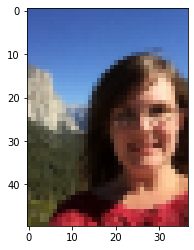

In [6]:
plt.imshow(train_small_images[0])

In [7]:
train_small_images.shape

(1700, 50, 37, 3)

In [8]:
train_small_images[0].shape

(50, 37, 3)

In [9]:
train_big_images.shape

(1700, 100, 75, 3)

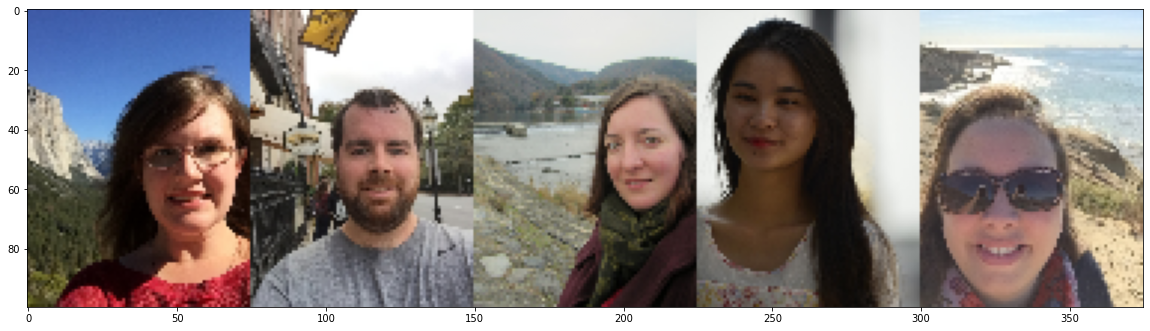

In [10]:
plt.figure(figsize=(20,6))
plt.imshow(train_big_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

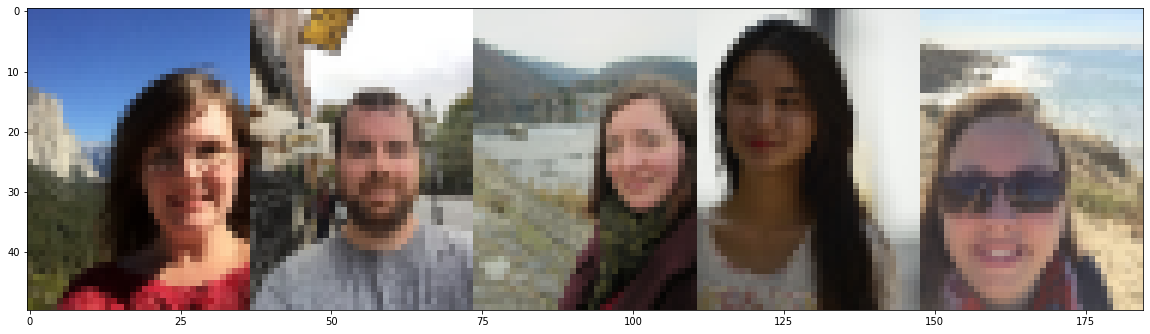

In [11]:
plt.figure(figsize=(20,6))
plt.imshow(train_small_images[:5].transpose((1,0,2,3)).reshape((50,-1,3)))
plt.show()

## Modeling

In [12]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel) :
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_resolution() :           # 작은이미지가 들어가면 큰 이미지가 출력되게 끔
    inputs = Input((50,37,3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
     
    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=(0,0))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(0,1))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(1,0))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)
    
    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    u10 = Conv2DTranspose(16, 2,2, padding='valid', output_padding=(0,1))(c9)
    outputs = Conv2D(3, 1, activation='sigmoid')(u10)
    
    model = Model(inputs, outputs) #c5
    return model


In [14]:
model = unet_resolution()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 50, 37, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 50, 37, 16)   64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 50, 37, 16)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [15]:
model.compile(
    loss = 'mae', 
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
hist = model.fit(train_small_images, train_big_images,
          validation_data = (test_small_images, test_big_images),
          epochs = 25,
          verbose = 1)

In [ ]:
res = model.predict(test_small_images[1:2])

In [ ]:
exp = resize(test_small_images[1], (100,75))
exp.shape